In [7]:
###
#Goal: See how varying OM1curvature will effect the mode-matching in OMC
#First we use all of the aLIGO cavities to derive the ideal mode-matching parameters
#then we extract the beam quality from BS to SRC
#
# then we turn off all the cavities and inject the beam.
###

In [8]:
%matplotlib inline
import pykat
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np
from pykat.parallel import parakat

pandas.set_eng_float_format(accuracy=3, use_eng_prefix=True)

In [9]:
####Perfect Mode-Matching Version:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem2.kat"

basekat = pykat.finesse.kat()
basekat.loadKatFile(katfile)

# Add cavity parameter detectors
basekat.parseCommands("""

tf sus 1 0 p $mech_fres $mech_Q
const mech_fres 1  # Approx. resonance frequency
const mech_Q    1M # Guess for suspension Q factor

sq sqz 0 10 0 nsqz

bp inputxq x q nOFIout
bp inputyq y q nOFIout

bp outputxq x q nOM2a
bp outputyq y q nOM2a

yaxis lin re:im
""")

basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.noxaxis = True
kat.verbose = False
out = kat.run()

inputxq = out['inputxq']
inputyq = out['inputyq']


Parsing `put lx1 L $Lmx` into pykat object not implemented yet, added as extra line.
Parsing `put ly1 L $Lmy` into pykat object not implemented yet, added as extra line.


In [10]:
katfile1 = "aLIGO_IFO_AWC_tuning_DCoff_maxtem2.kat"

basekat = pykat.finesse.kat()
basekat.loadKatFile(katfile1)
basekat.undumpNodes() #undump the vacuum nodes

#gauss_string = 'gauss** gaussin L0 nSRBS ' + str(inputxw) + ' ' \
#+ str(inputxr)+' '\
#+ str(inputyw) + ' '\
#+ str(inputyr)

gauss_string = 'gauss* gaussin mOPinterface nOFIout ' + str(float(np.real(inputxq))) +' '+ str(float(np.imag(inputxq)))+ ' '\
 + str(float(np.real(inputyq))) +' '+ str(float(np.imag(inputyq)))
print(gauss_string)
basekat.parseCommands(gauss_string)
basekat.parseCommands("""

startnode nOFIout

tf sus 1 0 p $mech_fres $mech_Q
const mech_fres 1  # Approx. resonance frequency
const mech_Q    1M # Guess for suspension Q factor

# Differentially modulate the strain in the arms
fsig darm  LXarm 1 0 1
fsig darm2 LYarm 1 180 1

bp outputxq x q nOM2a
bp outputyq y q nOM2a

sq sqz 0 10 0 nsqz

qnoisedS NSR_with_RP    1 $fs nOMC_AROC_trans

qnoisedS NSR 1 $fs max nOMC_AROC_trans
xaxis darm f log 5 5k 500
yaxis re:im
""")

Parsing `put lx1 L $Lmx` into pykat object not implemented yet, added as extra line.
Parsing `put ly1 L $Lmy` into pykat object not implemented yet, added as extra line.
gauss* gaussin mOPinterface nOFIout -4.66044588440796 1.84590481313176 -4.78682705667503 1.64715604061559
Parsing `startnode nOFIout` into pykat object not implemented yet, added as extra line.


In [11]:
kat1=basekat.deepcopy() #copy kat code

pk = parakat()

OM1_Rc = kat1.OM1.Rc.value

Rc_mismatch = []

for i in range(0,60,5):
    mm = float(i)/100.
    Rc_mismatch.append(mm)
    kat1.OM1.Rc = OM1_Rc*(1 - mm)
    pk.run(kat1, cmd_args=["-cr=on"])
    
outs = pk.getResults()

pk.clear()
pk.close()

Parallel jobs: 100%|##########################################################|

In [12]:
darm_list = []
q_old = []
q_new = []
for i,out in enumerate(outs):
    darm_list.append(outs[i]['NSR_with_RP'])
    
hbar=6.62606957E-34/(2.0 *np.pi)
m = 40.
L = 3994.5
SQL_x = np.sqrt( 8 * hbar / ( m * (2*np.pi*out.x)**2)) / L

In [13]:
q_perfect = outs[0]['outputxq'][0]

mode_mismatch =[]

for i in range(len(darm_list)):
    q_new = outs[i]['outputxq'][0]
    print(q_new)
    mm = 100*(  1-pykat.beam_param.overlap(q_perfect, q_new  ))
    mode_mismatch.append(mm)
 

(0.509281509238+1.20331090616j)
(0.495691864067+1.15509888129j)
(0.484114059066+1.10308377453j)
(0.47509567689+1.04710079343j)
(0.469274385981+0.987038182858j)
(0.467382343345+0.922861467303j)
(0.470245880209+0.85464311298j)
(0.478777959538+0.782597407481j)
(0.493960383402+0.707119449652j)
(0.516812457925+0.628825803074j)
(0.548343064732+0.548592594034j)
(0.58948418373+0.467584779357j)


In [14]:
gwinc_data = np.genfromtxt('./GwincOutput125W.csv', delimiter=',')
headers = ['Freq','MirrorThermal','Newtonian','Quantum','ResGas','Seismic','SuspThermal','Total']

Freq = []
MirrorThermal = []
Newtonian = []
Quantum = []
ResGas = []
Seismic = []
SuspThermal = []
Total = []
for i in range(len(gwinc_data)):
    Freq.append(gwinc_data[i][0])
    MirrorThermal.append(math.sqrt(gwinc_data[i][1]))
    Newtonian.append(math.sqrt(gwinc_data[i][2]))
    Quantum.append(math.sqrt(gwinc_data[i][3]))
    ResGas.append(math.sqrt(gwinc_data[i][4]))
    Seismic.append(math.sqrt(gwinc_data[i][5]))
    SuspThermal.append(math.sqrt(gwinc_data[i][6]))
    Total.append(math.sqrt(gwinc_data[i][7]))

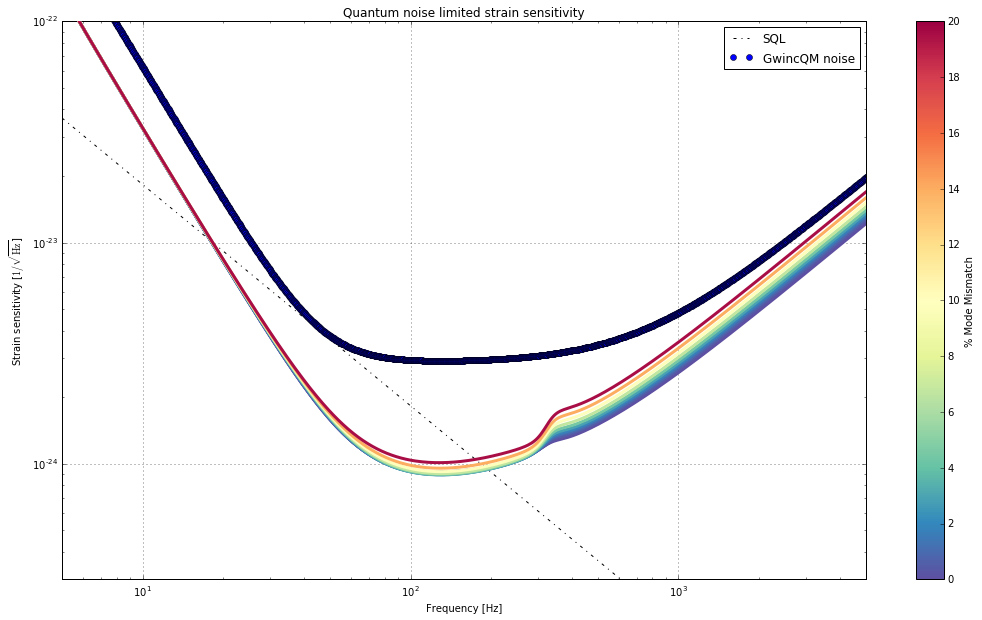

In [15]:
matplotlib.RcParams.update({'font.size', 'Large'})

pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(0, 20)

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm_list)):
    c = c = s_m.to_rgba(mode_mismatch[i])
    pl.subplot(111)
    pl.loglog(out.x, np.real(darm_list[i]),linewidth=3,zorder=1000, color = c,)
    
pl.subplot(111)

plt.loglog(out.x,SQL_x,'-.',color='k', label='SQL')

plt.loglog(Freq,Quantum,'o',label='GwincQM noise')


#pl.loglog(out.x, darm_list[0],out.x, darm_list[1],out.x, darm_list[2],out.x, darm_list[3],out.x, darm_list[4], color = c )
pl.title("Quantum noise limited strain sensitivity")
pl.xlim(out.x.min(),out.x.max())
pl.ylim(3e-25,1e-22)
pl.grid(True, zorder=-1)
pl.legend()

pl.xlabel("Frequency [Hz]")
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]")

cb = pl.colorbar(s_m)
cb.set_label("% Mode Mismatch")
#pylab.savefig("fc_mismatch_to_sqz_ifo_maxtem_%i_sqzing_%g.pdf" % (maxtem, kat.sqz.db))


pl.show()